In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Eventually, for Anaconda warnings.
# Can be commented out.
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load basic libraries
import seaborn; seaborn.set()
from itertools import chain
import pickle, copy
import numpy as np
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn_crfsuite import scorers, metrics

In [13]:
%%time
# Load data
from data_loader import loader

#bids = ["LO10016101","RAV0164473","LO10015953"]
#data, report = loader(bids, use_journals=True, use_monographs=True, which_mongo="mongo_sand", load_ann=True, prune_lines=True, verbose=True)
data, report = loader(None, use_journals=True, use_monographs=True, which_mongo="mongo_sand", load_ann=True, prune_lines=True, verbose=True)

{'primary-full': 3185, 'secondary-full': 11757, 'meta-annotation': 5655, 'secondary-partial': 10462, 'primary-partial': 2221}
{'primary-full': 3185, 'secondary-full': 14052, 'meta-annotation': 5656, 'secondary-partial': 13409, 'primary-partial': 2221}
CPU times: user 26min 59s, sys: 44.1 s, total: 27min 43s
Wall time: 28min 38s


In [14]:
# Dump data for further reuse
pickle.dump(data, open("data/test_data.p", "wb"))
pickle.dump(report, open("data/test_report.p", "wb"))

In [3]:
# Dump data for further reuse
data = pickle.load(open("data/test_data.p", "rb"))
report = pickle.load(open("data/test_report.p", "rb"))

In [4]:
print(report)

{'avg annotated docs over total docs': 0.22308288148721922, 'total_general': 33280, 'total_annotations': 161691, 'positive_results': 1, 'total_general_per_class_m': {'primary-partial': 457, 'primary-full': 111, 'secondary-full': 6228, 'secondary-partial': 2072, 'meta-annotation': 2367}, 'total_general_per_class_nofilter': {'primary-partial': 2221, 'primary-full': 3185, 'secondary-full': 14052, 'secondary-partial': 13409, 'meta-annotation': 5656}, 'total_general_j': 22045, 'total_specific_per_class': defaultdict(<class 'int'>, {'parchment': 20, 'editor': 2978, 'pagination': 13985, 'notary': 160, 'archivalunit': 126, 'cartulation': 1540, 'box': 1597, 'website': 6, 'publicationnumber-year': 2264, 'fascicolo': 191, 'chapter': 88, 'author': 18300, 'year': 210, 'mazzo': 17, 'cedola': 9, 'abbreviation': 3309, 'table': 70, 'curator': 1, 'foliation': 1313, 'library': 479, 'registry': 979, 'publisher': 3048, 'other': 248, 'tomo': 418, 'publicationyear': 12393, 'citation': 11, 'conjunction': 4751

In [5]:
for doc in data:
    for page in doc["pages"].values():
        if page["page_id"]=="RAV0164473-1953_137-page-0017":
            print(page)

{'is_annotated': True, 'page_mongo_id': ObjectId('56d5a04afe768325f46b3c17'), 'page_id': 'RAV0164473-1953_137-page-0017', 'offsets': [(('(1)', 970, 973, 1, 13, 'RAV0164473'), (False, False, 'small'), ('', '', 'o', 'o')), (('Alberto', 973, 980, 2, 13, 'RAV0164473'), (False, False, 'small'), ('secondary-full', 'author', 'b', 'b-secondary-full')), (('Errera', 981, 987, 3, 13, 'RAV0164473'), (False, False, 'small'), ('secondary-full', 'author', 'i', 'i-secondary-full')), (('e', 988, 989, 4, 13, 'RAV0164473'), (False, False, 'small'), ('secondary-full', 'author', 'i', 'i-secondary-full')), (('Cesare', 990, 996, 5, 13, 'RAV0164473'), (False, False, 'small'), ('secondary-full', 'author', 'i', 'i-secondary-full')), (('Finzi,', 997, 1003, 6, 13, 'RAV0164473'), (False, False, 'small'), ('secondary-full', 'author', 'i', 'i-secondary-full')), (('La', 1004, 1006, 7, 13, 'RAV0164473'), (False, False, 'small'), ('secondary-full', 'title', 'i', 'i-secondary-full')), (('vita', 1007, 1011, 8, 13, 'RAV01

In [ ]:
# DUMP annotations in a json, for release
# TODO: adapt this script to do use this dataset for annotations
d_ann = list()
for d in data:
    d_copy = copy.deepcopy(d)
    # delete mongo ids for the dump
    del d_copy["doc_mongo_id"]
    for p in d_copy["pages"].values():
        del p["page_mongo_id"]
    d_copy["pages"] = {k:p for k,p in d["pages"].items() if p["is_annotated"]} # only keep annotated pages
    d_ann.append(d_copy)
    
import json
with open('data/annotated_dataset.json', 'w+') as fp:
    json.dump(d_ann, fp, sort_keys=True, indent=4)

Tag consolidation to remove unfrequently used tags

In [6]:
# Specific Tag consolidation
correspondances = {
    'abbreviatedtitle': 'title', #
    'abbreviation': 'abbreviation', 
    'appendix': 'ref', #
    'archivalfond': 'archivalreference', #
    'archivalreference': 'archivalreference',
    'archivalseries': 'archivalreference', #
    'archivalunit': 'archivalreference', #
    'archive': 'archive_lib', #
    'attachment': 'attachment',
    'author': 'author',
    'box': 'box',
    'cartulation': 'cartulation', 
    'cedola': 'ref', #
    'century': 'date', #
    'chapter': 'ref', #
    'citation': 'ref', #
    'codex': 'archivalreference', #
    'column': 'column',
    'conjunction': 'conjunction', 
    'curator': 'author', #
    'date': 'date', 
    'editor': 'author', #
    'fascicolo': 'folder', #
    'filza': 'filza',
    'folder': 'folder',
    'foliation': 'foliation',
    'fond': 'archivalreference', #
    'implicit': '',
    'library': 'archive_lib', #
    'mazzo': 'ref', #
    'notary': 'archivalreference', #
    'note': 'numbered_ref', #
    'numbering': 'numbered_ref', #
    'other': '', #
    'pagination': 'pagination',
    'parchment': 'ref', #
    'period': 'date', #
    'protocollo': 'ref', #
    'parte': 'ref', #
    'publicationnumber': 'publicationnumber-year', #
    'publicationnumber-year': 'publicationnumber-year',
    'publicationplace': 'publicationplace',
    'publicationspecifications': 'publicationspecifications',
    'publicationyear': 'year', #
    'publisher': 'publisher',
    'registry': 'registry',
    'responsible': 'author', #
    'series': 'series',
    'table': 'ref', #
    'title': 'title',
    'tomo': 'tomo',
    'topicdate': 'publicationplace', #
    'voce': 'ref', #
    'volume': 'volume',
    'website': 'ref', #
    'year': 'year',
    '': ''
}

# define supporting functions
window = 2 # the window of dependance for the CRFs: use plus and minus that number as a context
from feature_extraction_words import word2features, generate_featuresLight
def text2features(text):
    return [word2features(text, i, window = window) for i in range(len(text))]
def text2featuresL(text):
    return [word2features(text, i, window = window, feature_function=generate_featuresLight) for i in range(len(text))]

# create beginend tags Y
def text2labelsBE(text):
    return [token[2][2] for token in text]

# create tagged-beginend tags Y
def text2labelsTBE(text):
    return [token[2][3] for token in text]

# create specific tags Y
def text2labelsS(text):
    return [correspondances[token[2][1]] for token in text]

In [7]:
# prepare annotated data for CRF
annotated_data = list()
for doc in data:
    doc_data_ann = list()
    for page in doc["pages"].values():
        if page["is_annotated"]:
            doc_data_ann.extend(page["offsets"])
    if len(doc_data_ann) > 0:
        annotated_data.append(doc_data_ann)
print(len(annotated_data))
print(len(data))

287
1291


In [8]:
%%time
# Define train and test sets
from sklearn.model_selection import train_test_split
d = [text2features(text) for text in annotated_data]
l = [text2labelsS(text) for text in annotated_data]
l_tbe = [text2labelsTBE(text) for text in annotated_data]
# Clean tag space
labels_to_keep = list(set([x for y in l for x in y]))
labels_to_keep_tbe = list(set([x for y in l_tbe for x in y]))
# VALIDATION set
X_rest, X_valid, y_rest, y_valid = train_test_split(d, l, test_size=0.1)
# TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(X_rest, y_rest, test_size=0.25)

/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


CPU times: user 2min 11s, sys: 4.87 s, total: 2min 16s
Wall time: 2min 16s


In [9]:
# Count labels
counts = {x:0 for x in labels_to_keep}
for c in counts.keys():
    counts[c] = len([x for y in l for x in y if x==c])
print(counts)
counts = {x:0 for x in labels_to_keep_tbe}
for c in counts.keys():
    counts[c] = len([x for y in l_tbe for x in y if x==c])
print(counts)

{'': 79488, 'title': 174228, 'publicationplace': 12346, 'abbreviation': 4293, 'cartulation': 3544, 'archive_lib': 5306, 'year': 13005, 'publicationnumber-year': 5905, 'registry': 2211, 'folder': 1526, 'attachment': 5206, 'date': 6860, 'series': 844, 'tomo': 870, 'numbered_ref': 5708, 'foliation': 2825, 'volume': 5428, 'author': 48211, 'ref': 1335, 'filza': 846, 'box': 2670, 'column': 529, 'publisher': 7060, 'conjunction': 4707, 'pagination': 26127, 'archivalreference': 15248, 'publicationspecifications': 5572}
{'b-primary-full': 3167, 'e-primary-partial': 2215, 'i-meta-annotation': 115126, 'b-primary-partial': 2160, 'b-secondary-full': 9007, 'i-secondary-partial': 36556, 'b-secondary-partial': 7064, 'i-primary-full': 31489, 'e-secondary-full': 9110, 'o': 78105, 'e-secondary-partial': 7124, 'i-secondary-full': 114937, 'e-meta-annotation': 5614, 'e-primary-full': 3180, 'i-primary-partial': 11457, 'b-meta-annotation': 5587}


In [36]:
# An example use of CRFs
crf = sklearn_crfsuite.CRF( 
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=False
)
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels_to_keep, digits=3
))

                           precision    recall  f1-score   support

                               0.811     0.846     0.828     20388
         publicationplace      0.850     0.855     0.852      2897
             numbered_ref      0.478     0.437     0.457      1166
              cartulation      0.873     0.773     0.820       824
publicationspecifications      0.584     0.273     0.372      1639
             abbreviation      0.665     0.682     0.674      1050
                      box      0.529     0.443     0.482       718
   publicationnumber-year      0.835     0.733     0.781      1668
                      ref      0.497     0.244     0.327       295
                     tomo      0.541     0.219     0.311       151
                    title      0.869     0.941     0.904     41425
              archive_lib      0.866     0.783     0.822      1135
                   folder      0.538     0.230     0.322       487
               attachment      0.490     0.319     0.386     

In [19]:
%%time
# Parameters search
crf = sklearn_crfsuite.CRF( 
    max_iterations=100,
    algorithm = 'lbfgs',
    all_possible_transitions=False
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05)
}

from sklearn.metrics import make_scorer
from support_functions import BER
scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels_to_keep)
#scorer = make_scorer(BER, greater_is_better=True)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-10, 
                        n_iter=5, 
                        scoring=scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-10)]: Done   2 out of  15 | elapsed: 17.1min remaining: 110.8min
[Parallel(n_jobs=-10)]: Done  15 out of  15 | elapsed: 24.8min finished


CPU times: user 25min 15s, sys: 1min 17s, total: 26min 32s
Wall time: 45min 35s


In [20]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)

best params: {'c2': 0.17849696199496759, 'c1': 0.36042615370272441}
best CV score: 0.842435998419


Dark blue => 0.8365, dark red => 0.8424


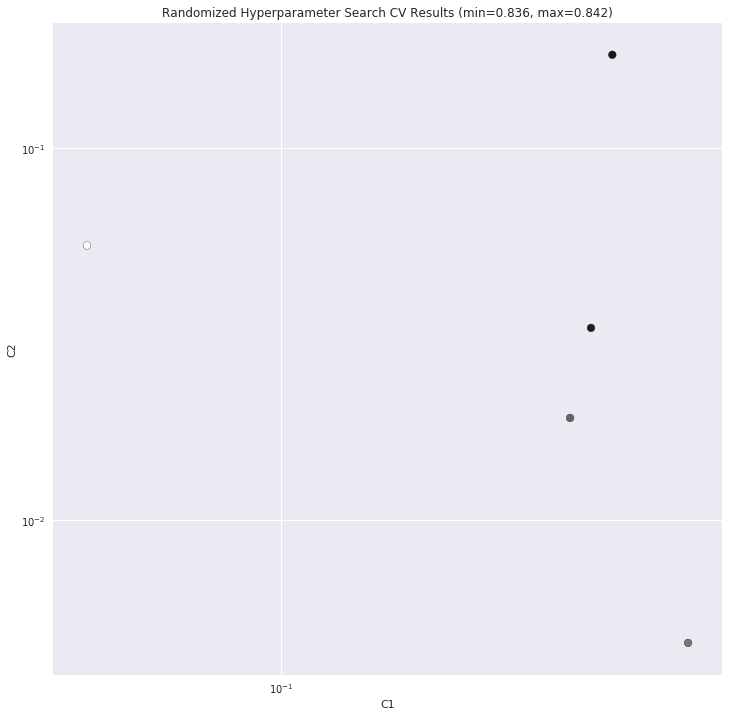

In [21]:
# Explore paramether space
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

                           precision    recall  f1-score   support

                               0.835     0.874     0.854     24531
             numbered_ref      0.561     0.403     0.469      1294
                   folder      0.496     0.386     0.435       176
              cartulation      0.921     0.894     0.907      1336
             abbreviation      0.771     0.729     0.750      1063
               attachment      0.198     0.203     0.200       474
                 registry      0.695     0.806     0.747       459
                      box      0.789     0.829     0.809       645
                   volume      0.647     0.496     0.561      1250
                     year      0.934     0.867     0.899      2871
                    title      0.895     0.929     0.912     40419
              conjunction      0.857     0.783     0.819       867
publicationspecifications      0.479     0.448     0.463      1060
               pagination      0.903     0.936     0.919     

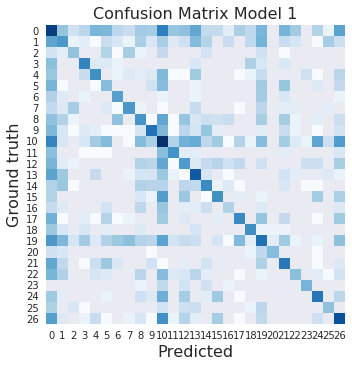

In [22]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels_to_keep, digits=3
))
# Confusion matrices
from sklearn.metrics import confusion_matrix
from support_functions import flatten_predictions

print(confusion_matrix(flatten_predictions(y_test), flatten_predictions(y_pred), labels=labels_to_keep))
plt.imshow(np.log(confusion_matrix(flatten_predictions(y_test), flatten_predictions(y_pred), labels=labels_to_keep)),
           cmap='Blues', interpolation='nearest')
plt.grid(False)
plt.ylabel('Ground truth', fontsize=16)
plt.xlabel('Predicted', fontsize=16)
plt.xticks(np.arange(0, len(labels_to_keep), 1))
plt.yticks(np.arange(0, len(labels_to_keep), 1))
plt.title("Confusion Matrix Model 1", fontsize=16)
plt.savefig("plots/conf_M1_ALL.pdf")
#M = np.argsort(confusion_matrix(flatten_predictions(y_test), flatten_predictions(y_pred), labels=labels_to_keep), axis=1)
#print(M[:,-5:])

In [11]:
# K-fold validation
from sklearn.model_selection import cross_val_score
from support_functions import BER
from sklearn.metrics import make_scorer
scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels_to_keep)
# use balanced error rate if all tags are equally important. Usually, this is not the case.
scorer2 = make_scorer(BER, greater_is_better=True)

# plug here your params, or use rs.best_params_
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c2= 0.17849696199496759, c1= 0.36042615370272441,
    max_iterations=200, 
    all_possible_transitions=True
)
k = 5

cv = cross_val_score(crf, X_rest, y_rest, cv=k, scoring=scorer, n_jobs=-2)
print("%d-fold validation mean: "%k,cv.mean())
#cv = cross_val_score(crf, X_rest, y_rest, cv=k, scoring=scorer2, n_jobs=-2)
#print("%d-fold validation mean: "%k,cv.mean())

/root/anaconda3/envs/lb_main_analysis/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


5-fold validation mean:  0.853739175407
5-fold validation mean:  0.319549720972


MemoryError: 

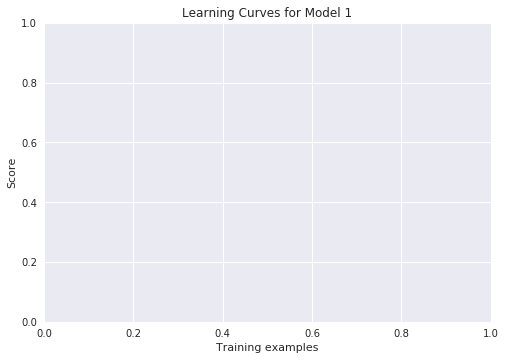

In [9]:
# Learning curves
# Watch out, this takes up a lot of primary memory
from sklearn import cross_validation
from support_functions import plot_learning_curve

# Slices of data for learning curves
train_sizes=np.linspace(0.1, 1.0, 10)
title = "Learning Curves for Model 1"
message = "M1"
# Cross validation scheme with 80-20 splits and 5 iterations per train data size (to evaluate variance)
cv = cross_validation.ShuffleSplit(len(X_rest), n_iter=3,
                                   test_size=0.2, random_state=0)
estimator = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c2= 0.17849696199496759, c1= 0.36042615370272441,
    max_iterations=100, 
    all_possible_transitions=False
)
plot_learning_curve(estimator, title, X_rest, y_rest, labels_to_keep, cv=cv, train_sizes=train_sizes, n_jobs=10, message=message)

In [ ]:
%%time
# VALIDATION

crf = sklearn_crfsuite.CRF( 
    algorithm='lbfgs',
    c2= 0.17849696199496759, c1= 0.36042615370272441,
    max_iterations=500,
    all_possible_transitions=True
)
crf.fit(X_rest, y_rest)
y_pred = crf.predict(X_valid)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=labels_to_keep, digits=3
))

                           precision    recall  f1-score   support

                               0.793     0.898     0.843      6915
                publisher      0.866     0.708     0.779       787
                   column      0.810     0.179     0.293        95
                   folder      0.632     0.568     0.598       345
                      box      0.470     0.377     0.419       167
                    title      0.914     0.936     0.925     14248
                   volume      0.575     0.500     0.535       344
             numbered_ref      0.676     0.516     0.585       767
                     date      0.745     0.852     0.795       815
         publicationplace      0.887     0.904     0.896      1158
   publicationnumber-year      0.808     0.781     0.794       420
                   author      0.878     0.906     0.892      4297
                 registry      0.861     0.377     0.524       247
                foliation      0.866     0.936     0.900     

In [ ]:
# Train final models for task 1
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c2= 0.17849696199496759, c1= 0.36042615370272441,
    max_iterations=500, 
    all_possible_transitions=True
)
crf.fit(d, l)

# save model
from sklearn.externals import joblib
joblib.dump(crf,'models/modelM1_ALL_L.pkl')

['models/modelM1_ALL_L.pkl']

Apply model to new data. This needs to move outside of the notebook.

In [10]:
# load model
from sklearn.externals import joblib
crf1 = joblib.load('models/modelM1_ALL_L.pkl')

In [11]:
def process_document(doc):
    for page in doc["pages"].values():
        if not page["is_annotated"]:
            data_to_tag = [text2features(page["offsets"])]
            page_lab = crf1.predict(data_to_tag)
            assert len(page_lab[0]) == len(page["offsets"])
            page.update({"specific_tags":page_lab[0]})
        else:
            page.update({"specific_tags":text2labelsS(page["offsets"])})
    return doc
            
from multiprocessing import Pool
threads = Pool(45)

In [12]:
# parse all
data2 = list()
for ar in threads.imap_unordered(process_document, data):
    data2.append(ar)

In [13]:
pickle.dump(data2, open("data/test_data.p", "wb"))